In [1]:
from models import unet_valid
from data_generator import batch_data_generator 
import matplotlib.pyplot as plt
import numpy as np

# from importlib import reload
# reload(data)
# reload(model)

In [2]:
# for Gunpowder
ZARR_FOLDER_TRAIN = '../../../../data/cells/raw/zarr/train/'
ZARR_FOLDER_TEST = '../../../../data/cells/raw/zarr/test/'
gp_batch_size= 1
gp_voxel_shape = [1,1,1]
gp_input_shape= [572, 572,4]
gp_output_shape = [ 388, 388,3]

# For unet
OUTPUT_PATH = '../../../../data/cells/models/'

unet_input_size = (572, 572,4)
unet_output_size = 3

In [3]:
from datetime import date

today = date.today()

d1 = today.strftime("%d_%m_%Y_")
# model_name

### Check data 

In [4]:
gen_train_fast = batch_data_generator(ZARR_FOLDER_TRAIN, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,
                                              output_shape = gp_output_shape,without_background=True )

gen_test_fast = batch_data_generator(ZARR_FOLDER_TEST, batch_size=gp_batch_size
                                              ,voxel_shape = gp_voxel_shape,
                                              input_shape= gp_input_shape,
                                             output_shape = gp_output_shape,without_background = True )

In [5]:
im,mask = next(gen_test_fast)
print(im.shape)
print(mask.shape)

Difference padding: 92
(1, 572, 572, 4)
(1, 388, 388, 3)


In [6]:
test_im = im[0]
test_mask = mask[0]
np.unique(test_mask)
print(np.unique(test_mask))
print('Img size: {} {} < {} | Mask size: {} {} <{}'.format(test_im.shape,test_im.dtype,test_im.max()
                                                                   ,test_mask.shape,test_mask.dtype,test_mask.max()))

[0. 1.]
Img size: (572, 572, 4) float32 < 1.0 | Mask size: (388, 388, 3) float32 <1.0


In [7]:
# n = test_mask.argmax(axis=2)
# print(np.unique(n))
# plt.imshow(n)

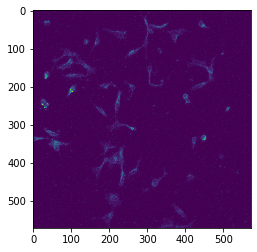

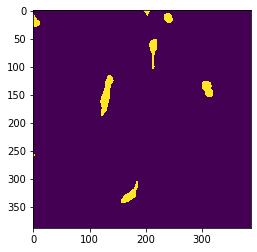

In [8]:
plt.imshow(test_im[:,:,2])
plt.show()
plt.imshow(test_mask[:,:,0])
plt.show()

### Model

In [9]:
model = unet_valid(input_size = unet_input_size ,output_size = unet_output_size)

In [10]:
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
model.compile(optimizer = Adam(lr = 1e-4), loss = mean_squared_error, metrics=['accuracy', MeanIoU( num_classes=unet_output_size)])


In [11]:
# model.summary()

### Train

In [12]:
base_name = d1+'test_4_big'
model_name = base_name+'.hdf5'

In [13]:
import os
GRAPHS_FOLDER = '../../../../data/cells/graphs/'
GRAPH_NAME = os.path.join(GRAPHS_FOLDER,base_name+'.png')

from tensorflow import keras
import IPython.display as display
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.history = {}
        self.fig = plt.figure()
        
        self.logs = []
#         plt.show()

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        for l in logs:
            if l not in self.history:
                self.history[l]=[]
            self.history[l].append(logs.get(l))
        self.i += 1
        
        display.clear_output(wait=True)
        for l in logs:
            plt.plot(self.x, self.history[l], label=l)
        plt.legend()
        plt.savefig(GRAPH_NAME)
        plt.show();
        
plot_losses = PlotLosses()

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import os
# import PersonalizedCallbacks

model_file = os.path.join(OUTPUT_PATH,model_name)
# mean_io_u
model_checkpoint = ModelCheckpoint(model_file, monitor='val_loss',verbose=0, save_best_only=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [15]:
# model_checkpoint,plot_losses
# 
history = model.fit_generator(gen_train_fast,steps_per_epoch=50,
                                   validation_data = gen_test_fast,validation_steps=10,
                                   epochs=2000,callbacks=[model_checkpoint],verbose=1)


Epoch 1/2000
Difference padding: 92
50/50 [==============================] - 22s 444ms/step - loss: 0.1182 - accuracy: 0.2441 - mean_io_u: 0.4854 - val_loss: 0.1172 - val_accuracy: 0.0423 - val_mean_io_u: 0.4879
Epoch 2/2000
50/50 [==============================] - 17s 349ms/step - loss: 0.1160 - accuracy: 0.1240 - mean_io_u: 0.4870 - val_loss: 0.1167 - val_accuracy: 0.1141 - val_mean_io_u: 0.4869
Epoch 3/2000
50/50 [==============================] - 16s 327ms/step - loss: 0.1161 - accuracy: 0.3681 - mean_io_u: 0.4867 - val_loss: 0.1172 - val_accuracy: 0.3326 - val_mean_io_u: 0.4871
Epoch 4/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1156 - accuracy: 0.2264 - mean_io_u: 0.4873 - val_loss: 0.1174 - val_accuracy: 0.4128 - val_mean_io_u: 0.4872
Epoch 5/2000
50/50 [==============================] - 18s 369ms/step - loss: 0.1158 - accuracy: 0.2700 - mean_io_u: 0.4867 - val_loss: 0.1159 - val_accuracy: 0.0894 - val_mean_io_u: 0.4874
Epoch 6/2000
50/50 [============

50/50 [==============================] - 17s 337ms/step - loss: 0.1030 - accuracy: 0.3106 - mean_io_u: 0.5529 - val_loss: 0.1248 - val_accuracy: 0.2095 - val_mean_io_u: 0.4985
Epoch 45/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1034 - accuracy: 0.3218 - mean_io_u: 0.5647 - val_loss: 0.1234 - val_accuracy: 0.3392 - val_mean_io_u: 0.4945
Epoch 46/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1030 - accuracy: 0.4529 - mean_io_u: 0.5821 - val_loss: 0.1244 - val_accuracy: 0.1711 - val_mean_io_u: 0.4979
Epoch 47/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1025 - accuracy: 0.3262 - mean_io_u: 0.5659 - val_loss: 0.1237 - val_accuracy: 0.7527 - val_mean_io_u: 0.4956
Epoch 48/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1035 - accuracy: 0.3929 - mean_io_u: 0.5783 - val_loss: 0.1259 - val_accuracy: 0.7259 - val_mean_io_u: 0.4900
Epoch 49/2000
50/50 [==============================] - 17s 339ms

50/50 [==============================] - 17s 338ms/step - loss: 0.1027 - accuracy: 0.3387 - mean_io_u: 0.7824 - val_loss: 0.1244 - val_accuracy: 0.1632 - val_mean_io_u: 0.5170
Epoch 88/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1026 - accuracy: 0.3254 - mean_io_u: 0.7624 - val_loss: 0.1247 - val_accuracy: 0.6242 - val_mean_io_u: 0.5106
Epoch 89/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1026 - accuracy: 0.3703 - mean_io_u: 0.7725 - val_loss: 0.1258 - val_accuracy: 0.1717 - val_mean_io_u: 0.5192
Epoch 90/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1023 - accuracy: 0.3122 - mean_io_u: 0.7662 - val_loss: 0.1255 - val_accuracy: 0.1314 - val_mean_io_u: 0.5084
Epoch 91/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1014 - accuracy: 0.3424 - mean_io_u: 0.7902 - val_loss: 0.1244 - val_accuracy: 0.3287 - val_mean_io_u: 0.5098
Epoch 92/2000
50/50 [==============================] - 17s 339ms

50/50 [==============================] - 17s 340ms/step - loss: 0.1018 - accuracy: 0.3539 - mean_io_u: 0.8508 - val_loss: 0.1242 - val_accuracy: 0.4982 - val_mean_io_u: 0.5346
Epoch 131/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1030 - accuracy: 0.3631 - mean_io_u: 0.8126 - val_loss: 0.1247 - val_accuracy: 0.7918 - val_mean_io_u: 0.5215
Epoch 132/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1031 - accuracy: 0.3674 - mean_io_u: 0.8095 - val_loss: 0.1239 - val_accuracy: 0.1370 - val_mean_io_u: 0.5361
Epoch 133/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1025 - accuracy: 0.3266 - mean_io_u: 0.8264 - val_loss: 0.1244 - val_accuracy: 0.2795 - val_mean_io_u: 0.5258
Epoch 134/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1033 - accuracy: 0.3485 - mean_io_u: 0.8218 - val_loss: 0.1250 - val_accuracy: 0.5059 - val_mean_io_u: 0.5222
Epoch 135/2000
50/50 [==============================] - 17s 

Epoch 173/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1027 - accuracy: 0.3894 - mean_io_u: 0.8291 - val_loss: 0.1253 - val_accuracy: 0.1716 - val_mean_io_u: 0.5413
Epoch 174/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1022 - accuracy: 0.3664 - mean_io_u: 0.8532 - val_loss: 0.1264 - val_accuracy: 0.2524 - val_mean_io_u: 0.5394
Epoch 175/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1025 - accuracy: 0.3741 - mean_io_u: 0.8668 - val_loss: 0.1266 - val_accuracy: 0.2655 - val_mean_io_u: 0.5638
Epoch 176/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1022 - accuracy: 0.3464 - mean_io_u: 0.8558 - val_loss: 0.1258 - val_accuracy: 0.3076 - val_mean_io_u: 0.5373
Epoch 177/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1021 - accuracy: 0.3218 - mean_io_u: 0.8625 - val_loss: 0.1262 - val_accuracy: 0.2748 - val_mean_io_u: 0.5331
Epoch 178/2000
50/50 [=======================

Epoch 216/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1024 - accuracy: 0.3440 - mean_io_u: 0.8943 - val_loss: 0.1249 - val_accuracy: 0.6671 - val_mean_io_u: 0.5194
Epoch 217/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1018 - accuracy: 0.3887 - mean_io_u: 0.8961 - val_loss: 0.1246 - val_accuracy: 0.5861 - val_mean_io_u: 0.5239
Epoch 218/2000
50/50 [==============================] - 17s 343ms/step - loss: 0.1023 - accuracy: 0.4166 - mean_io_u: 0.8979 - val_loss: 0.1233 - val_accuracy: 0.7601 - val_mean_io_u: 0.5348
Epoch 219/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1025 - accuracy: 0.3568 - mean_io_u: 0.8908 - val_loss: 0.1246 - val_accuracy: 0.0498 - val_mean_io_u: 0.5258
Epoch 220/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1026 - accuracy: 0.3503 - mean_io_u: 0.8881 - val_loss: 0.1244 - val_accuracy: 0.2361 - val_mean_io_u: 0.5152
Epoch 221/2000
50/50 [=======================

Epoch 259/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1022 - accuracy: 0.3825 - mean_io_u: 0.9142 - val_loss: 0.1270 - val_accuracy: 0.8346 - val_mean_io_u: 0.5302
Epoch 260/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1009 - accuracy: 0.3517 - mean_io_u: 0.9211 - val_loss: 0.1249 - val_accuracy: 0.3659 - val_mean_io_u: 0.5394
Epoch 261/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1021 - accuracy: 0.4446 - mean_io_u: 0.9184 - val_loss: 0.1240 - val_accuracy: 0.1162 - val_mean_io_u: 0.5447
Epoch 262/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1031 - accuracy: 0.3235 - mean_io_u: 0.9122 - val_loss: 0.1256 - val_accuracy: 0.1806 - val_mean_io_u: 0.5654
Epoch 263/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1027 - accuracy: 0.3928 - mean_io_u: 0.9188 - val_loss: 0.1248 - val_accuracy: 0.6480 - val_mean_io_u: 0.5506
Epoch 264/2000
50/50 [=======================

Epoch 302/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1029 - accuracy: 0.3997 - mean_io_u: 0.9107 - val_loss: 0.1255 - val_accuracy: 0.3086 - val_mean_io_u: 0.5383
Epoch 303/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1026 - accuracy: 0.3902 - mean_io_u: 0.9063 - val_loss: 0.1268 - val_accuracy: 0.1010 - val_mean_io_u: 0.5310
Epoch 304/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1028 - accuracy: 0.4053 - mean_io_u: 0.9100 - val_loss: 0.1264 - val_accuracy: 0.6226 - val_mean_io_u: 0.5382
Epoch 305/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1020 - accuracy: 0.3920 - mean_io_u: 0.9191 - val_loss: 0.1281 - val_accuracy: 0.1196 - val_mean_io_u: 0.5446
Epoch 306/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1026 - accuracy: 0.3808 - mean_io_u: 0.9225 - val_loss: 0.1263 - val_accuracy: 0.4833 - val_mean_io_u: 0.5385
Epoch 307/2000
50/50 [=======================

Epoch 345/2000
50/50 [==============================] - 17s 334ms/step - loss: 0.1022 - accuracy: 0.3661 - mean_io_u: 0.8767 - val_loss: 0.1293 - val_accuracy: 0.1816 - val_mean_io_u: 0.5424
Epoch 346/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1022 - accuracy: 0.3519 - mean_io_u: 0.8940 - val_loss: 0.1281 - val_accuracy: 0.2086 - val_mean_io_u: 0.5438
Epoch 347/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.4052 - mean_io_u: 0.9012 - val_loss: 0.1280 - val_accuracy: 0.4536 - val_mean_io_u: 0.5326
Epoch 348/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3774 - mean_io_u: 0.9007 - val_loss: 0.1281 - val_accuracy: 0.5936 - val_mean_io_u: 0.5365
Epoch 349/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1018 - accuracy: 0.3462 - mean_io_u: 0.8875 - val_loss: 0.1248 - val_accuracy: 0.4273 - val_mean_io_u: 0.5618
Epoch 350/2000
50/50 [=======================

Epoch 388/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1021 - accuracy: 0.3367 - mean_io_u: 0.9340 - val_loss: 0.1238 - val_accuracy: 0.0626 - val_mean_io_u: 0.5825
Epoch 389/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1035 - accuracy: 0.3387 - mean_io_u: 0.9302 - val_loss: 0.1247 - val_accuracy: 0.1253 - val_mean_io_u: 0.5624
Epoch 390/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1021 - accuracy: 0.3586 - mean_io_u: 0.9332 - val_loss: 0.1226 - val_accuracy: 0.1887 - val_mean_io_u: 0.5780
Epoch 391/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1022 - accuracy: 0.4218 - mean_io_u: 0.9365 - val_loss: 0.1261 - val_accuracy: 0.0733 - val_mean_io_u: 0.5521
Epoch 392/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1028 - accuracy: 0.4003 - mean_io_u: 0.9383 - val_loss: 0.1264 - val_accuracy: 0.0584 - val_mean_io_u: 0.5495
Epoch 393/2000
50/50 [=======================

Epoch 431/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1032 - accuracy: 0.4019 - mean_io_u: 0.9396 - val_loss: 0.1253 - val_accuracy: 0.1212 - val_mean_io_u: 0.5534
Epoch 432/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1021 - accuracy: 0.3392 - mean_io_u: 0.9410 - val_loss: 0.1263 - val_accuracy: 0.9036 - val_mean_io_u: 0.5576
Epoch 433/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1019 - accuracy: 0.4021 - mean_io_u: 0.9420 - val_loss: 0.1259 - val_accuracy: 0.2159 - val_mean_io_u: 0.5513
Epoch 434/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1019 - accuracy: 0.3354 - mean_io_u: 0.9402 - val_loss: 0.1260 - val_accuracy: 0.6727 - val_mean_io_u: 0.5511
Epoch 435/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.4432 - mean_io_u: 0.9313 - val_loss: 0.1250 - val_accuracy: 0.1120 - val_mean_io_u: 0.5563
Epoch 436/2000
50/50 [=======================

Epoch 474/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.4572 - mean_io_u: 0.9482 - val_loss: 0.1237 - val_accuracy: 0.2401 - val_mean_io_u: 0.5740
Epoch 475/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1024 - accuracy: 0.3921 - mean_io_u: 0.9476 - val_loss: 0.1257 - val_accuracy: 0.1994 - val_mean_io_u: 0.5556
Epoch 476/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.4027 - mean_io_u: 0.9494 - val_loss: 0.1244 - val_accuracy: 0.4325 - val_mean_io_u: 0.5664
Epoch 477/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1030 - accuracy: 0.3865 - mean_io_u: 0.9501 - val_loss: 0.1275 - val_accuracy: 0.3937 - val_mean_io_u: 0.5517
Epoch 478/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1015 - accuracy: 0.3805 - mean_io_u: 0.9513 - val_loss: 0.1262 - val_accuracy: 0.5765 - val_mean_io_u: 0.5532
Epoch 479/2000
50/50 [=======================

Epoch 517/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3739 - mean_io_u: 0.9480 - val_loss: 0.1253 - val_accuracy: 0.3260 - val_mean_io_u: 0.5610
Epoch 518/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1024 - accuracy: 0.3693 - mean_io_u: 0.9471 - val_loss: 0.1271 - val_accuracy: 0.2599 - val_mean_io_u: 0.5578
Epoch 519/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.3596 - mean_io_u: 0.9473 - val_loss: 0.1228 - val_accuracy: 0.2264 - val_mean_io_u: 0.5657
Epoch 520/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1016 - accuracy: 0.3925 - mean_io_u: 0.9478 - val_loss: 0.1247 - val_accuracy: 0.1546 - val_mean_io_u: 0.5725
Epoch 521/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1014 - accuracy: 0.3682 - mean_io_u: 0.9499 - val_loss: 0.1250 - val_accuracy: 0.2283 - val_mean_io_u: 0.5648
Epoch 522/2000
50/50 [=======================

Epoch 560/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1012 - accuracy: 0.3612 - mean_io_u: 0.9587 - val_loss: 0.1253 - val_accuracy: 0.2773 - val_mean_io_u: 0.5680
Epoch 561/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1020 - accuracy: 0.3667 - mean_io_u: 0.9567 - val_loss: 0.1243 - val_accuracy: 0.1164 - val_mean_io_u: 0.5723
Epoch 562/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1030 - accuracy: 0.3090 - mean_io_u: 0.9563 - val_loss: 0.1252 - val_accuracy: 0.3789 - val_mean_io_u: 0.5606
Epoch 563/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3627 - mean_io_u: 0.9558 - val_loss: 0.1255 - val_accuracy: 0.7383 - val_mean_io_u: 0.5647
Epoch 564/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1016 - accuracy: 0.4103 - mean_io_u: 0.9548 - val_loss: 0.1264 - val_accuracy: 0.5463 - val_mean_io_u: 0.5799
Epoch 565/2000
50/50 [=======================

Epoch 603/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1021 - accuracy: 0.3670 - mean_io_u: 0.9616 - val_loss: 0.1250 - val_accuracy: 0.2640 - val_mean_io_u: 0.5635
Epoch 604/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1030 - accuracy: 0.3420 - mean_io_u: 0.9563 - val_loss: 0.1245 - val_accuracy: 0.9181 - val_mean_io_u: 0.5548
Epoch 605/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.3642 - mean_io_u: 0.9464 - val_loss: 0.1243 - val_accuracy: 0.6819 - val_mean_io_u: 0.5515
Epoch 606/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1021 - accuracy: 0.3513 - mean_io_u: 0.9517 - val_loss: 0.1263 - val_accuracy: 0.0458 - val_mean_io_u: 0.5665
Epoch 607/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1015 - accuracy: 0.3471 - mean_io_u: 0.9492 - val_loss: 0.1246 - val_accuracy: 0.2635 - val_mean_io_u: 0.5792
Epoch 608/2000
50/50 [=======================

Epoch 646/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1025 - accuracy: 0.3385 - mean_io_u: 0.9475 - val_loss: 0.1264 - val_accuracy: 0.3061 - val_mean_io_u: 0.5748
Epoch 647/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1017 - accuracy: 0.3544 - mean_io_u: 0.9526 - val_loss: 0.1249 - val_accuracy: 0.1586 - val_mean_io_u: 0.5801
Epoch 648/2000
50/50 [==============================] - 17s 342ms/step - loss: 0.1026 - accuracy: 0.3695 - mean_io_u: 0.9519 - val_loss: 0.1254 - val_accuracy: 0.3100 - val_mean_io_u: 0.5843
Epoch 649/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1028 - accuracy: 0.3531 - mean_io_u: 0.9564 - val_loss: 0.1272 - val_accuracy: 0.1965 - val_mean_io_u: 0.5754
Epoch 650/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1024 - accuracy: 0.3689 - mean_io_u: 0.9566 - val_loss: 0.1257 - val_accuracy: 0.3327 - val_mean_io_u: 0.5778
Epoch 651/2000
50/50 [=======================

Epoch 689/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1026 - accuracy: 0.3841 - mean_io_u: 0.9594 - val_loss: 0.1244 - val_accuracy: 0.2739 - val_mean_io_u: 0.5748
Epoch 690/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1020 - accuracy: 0.4065 - mean_io_u: 0.9590 - val_loss: 0.1273 - val_accuracy: 0.1463 - val_mean_io_u: 0.5421
Epoch 691/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1026 - accuracy: 0.3760 - mean_io_u: 0.9610 - val_loss: 0.1268 - val_accuracy: 0.5100 - val_mean_io_u: 0.5555
Epoch 692/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1017 - accuracy: 0.3977 - mean_io_u: 0.9627 - val_loss: 0.1237 - val_accuracy: 0.3008 - val_mean_io_u: 0.5686
Epoch 693/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1011 - accuracy: 0.3882 - mean_io_u: 0.9622 - val_loss: 0.1239 - val_accuracy: 0.2194 - val_mean_io_u: 0.5762
Epoch 694/2000
50/50 [=======================

Epoch 732/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1018 - accuracy: 0.3245 - mean_io_u: 0.9570 - val_loss: 0.1247 - val_accuracy: 0.3003 - val_mean_io_u: 0.5710
Epoch 733/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1014 - accuracy: 0.3491 - mean_io_u: 0.9546 - val_loss: 0.1231 - val_accuracy: 0.3756 - val_mean_io_u: 0.5995
Epoch 734/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1019 - accuracy: 0.3632 - mean_io_u: 0.9575 - val_loss: 0.1246 - val_accuracy: 0.2819 - val_mean_io_u: 0.5715
Epoch 735/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1023 - accuracy: 0.3579 - mean_io_u: 0.9586 - val_loss: 0.1226 - val_accuracy: 0.2771 - val_mean_io_u: 0.5743
Epoch 736/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1018 - accuracy: 0.3598 - mean_io_u: 0.9591 - val_loss: 0.1225 - val_accuracy: 0.3647 - val_mean_io_u: 0.5727
Epoch 737/2000
50/50 [=======================

Epoch 775/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1019 - accuracy: 0.3665 - mean_io_u: 0.9653 - val_loss: 0.1271 - val_accuracy: 0.3188 - val_mean_io_u: 0.5557
Epoch 776/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1023 - accuracy: 0.3715 - mean_io_u: 0.9661 - val_loss: 0.1260 - val_accuracy: 0.6047 - val_mean_io_u: 0.5839
Epoch 777/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1021 - accuracy: 0.3698 - mean_io_u: 0.9649 - val_loss: 0.1263 - val_accuracy: 0.2095 - val_mean_io_u: 0.5761
Epoch 778/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1021 - accuracy: 0.3961 - mean_io_u: 0.9658 - val_loss: 0.1233 - val_accuracy: 0.6420 - val_mean_io_u: 0.5846
Epoch 779/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1025 - accuracy: 0.4200 - mean_io_u: 0.9651 - val_loss: 0.1271 - val_accuracy: 0.2788 - val_mean_io_u: 0.5599
Epoch 780/2000
50/50 [=======================

Epoch 818/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1015 - accuracy: 0.4225 - mean_io_u: 0.9645 - val_loss: 0.1249 - val_accuracy: 0.3804 - val_mean_io_u: 0.5851
Epoch 819/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1030 - accuracy: 0.3463 - mean_io_u: 0.9681 - val_loss: 0.1250 - val_accuracy: 0.1733 - val_mean_io_u: 0.5767
Epoch 820/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3285 - mean_io_u: 0.9671 - val_loss: 0.1266 - val_accuracy: 0.2925 - val_mean_io_u: 0.5622
Epoch 821/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1022 - accuracy: 0.3335 - mean_io_u: 0.9658 - val_loss: 0.1255 - val_accuracy: 0.3728 - val_mean_io_u: 0.5574
Epoch 822/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1017 - accuracy: 0.3622 - mean_io_u: 0.9647 - val_loss: 0.1272 - val_accuracy: 0.3358 - val_mean_io_u: 0.5545
Epoch 823/2000
50/50 [=======================

Epoch 861/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1021 - accuracy: 0.3761 - mean_io_u: 0.9627 - val_loss: 0.1243 - val_accuracy: 0.3675 - val_mean_io_u: 0.5706
Epoch 862/2000
50/50 [==============================] - 17s 342ms/step - loss: 0.1023 - accuracy: 0.3702 - mean_io_u: 0.9651 - val_loss: 0.1246 - val_accuracy: 0.4404 - val_mean_io_u: 0.5681
Epoch 863/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1023 - accuracy: 0.3533 - mean_io_u: 0.9647 - val_loss: 0.1235 - val_accuracy: 0.2770 - val_mean_io_u: 0.5850
Epoch 864/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1023 - accuracy: 0.3721 - mean_io_u: 0.9630 - val_loss: 0.1228 - val_accuracy: 0.3832 - val_mean_io_u: 0.5806
Epoch 865/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3990 - mean_io_u: 0.9654 - val_loss: 0.1244 - val_accuracy: 0.2089 - val_mean_io_u: 0.5628
Epoch 866/2000
50/50 [=======================

Epoch 904/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1014 - accuracy: 0.3402 - mean_io_u: 0.9647 - val_loss: 0.1239 - val_accuracy: 0.5167 - val_mean_io_u: 0.5883
Epoch 905/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1029 - accuracy: 0.3432 - mean_io_u: 0.9663 - val_loss: 0.1238 - val_accuracy: 0.3966 - val_mean_io_u: 0.5783
Epoch 906/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1015 - accuracy: 0.3782 - mean_io_u: 0.9658 - val_loss: 0.1241 - val_accuracy: 0.2794 - val_mean_io_u: 0.5811
Epoch 907/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1020 - accuracy: 0.3742 - mean_io_u: 0.9649 - val_loss: 0.1247 - val_accuracy: 0.3241 - val_mean_io_u: 0.5905
Epoch 908/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1021 - accuracy: 0.3561 - mean_io_u: 0.9655 - val_loss: 0.1247 - val_accuracy: 0.2717 - val_mean_io_u: 0.5768
Epoch 909/2000
50/50 [=======================

Epoch 947/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1019 - accuracy: 0.3587 - mean_io_u: 0.9643 - val_loss: 0.1267 - val_accuracy: 0.3260 - val_mean_io_u: 0.5665
Epoch 948/2000
50/50 [==============================] - 17s 331ms/step - loss: 0.1022 - accuracy: 0.3673 - mean_io_u: 0.9670 - val_loss: 0.1262 - val_accuracy: 0.2771 - val_mean_io_u: 0.5632
Epoch 949/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1027 - accuracy: 0.3796 - mean_io_u: 0.9658 - val_loss: 0.1261 - val_accuracy: 0.2250 - val_mean_io_u: 0.5651
Epoch 950/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1028 - accuracy: 0.3713 - mean_io_u: 0.9652 - val_loss: 0.1230 - val_accuracy: 0.7104 - val_mean_io_u: 0.5897
Epoch 951/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1020 - accuracy: 0.3846 - mean_io_u: 0.9673 - val_loss: 0.1240 - val_accuracy: 0.3004 - val_mean_io_u: 0.5672
Epoch 952/2000
50/50 [=======================

Epoch 990/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3589 - mean_io_u: 0.9599 - val_loss: 0.1246 - val_accuracy: 0.3756 - val_mean_io_u: 0.5665
Epoch 991/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.4298 - mean_io_u: 0.9626 - val_loss: 0.1257 - val_accuracy: 0.1969 - val_mean_io_u: 0.5542
Epoch 992/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1021 - accuracy: 0.3744 - mean_io_u: 0.9615 - val_loss: 0.1243 - val_accuracy: 0.3590 - val_mean_io_u: 0.5748
Epoch 993/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1021 - accuracy: 0.3773 - mean_io_u: 0.9629 - val_loss: 0.1274 - val_accuracy: 0.3728 - val_mean_io_u: 0.5551
Epoch 994/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1022 - accuracy: 0.3621 - mean_io_u: 0.9661 - val_loss: 0.1275 - val_accuracy: 0.2559 - val_mean_io_u: 0.5592
Epoch 995/2000
50/50 [=======================

Epoch 1033/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1021 - accuracy: 0.3676 - mean_io_u: 0.9721 - val_loss: 0.1256 - val_accuracy: 0.4575 - val_mean_io_u: 0.5630
Epoch 1034/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3697 - mean_io_u: 0.9722 - val_loss: 0.1275 - val_accuracy: 0.1004 - val_mean_io_u: 0.5562
Epoch 1035/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.3339 - mean_io_u: 0.9705 - val_loss: 0.1234 - val_accuracy: 0.2073 - val_mean_io_u: 0.5694
Epoch 1036/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1022 - accuracy: 0.3781 - mean_io_u: 0.9686 - val_loss: 0.1241 - val_accuracy: 0.4836 - val_mean_io_u: 0.5716
Epoch 1037/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1028 - accuracy: 0.3643 - mean_io_u: 0.9692 - val_loss: 0.1267 - val_accuracy: 0.3368 - val_mean_io_u: 0.5567
Epoch 1038/2000
50/50 [=================

Epoch 1076/2000
50/50 [==============================] - 17s 334ms/step - loss: 0.1028 - accuracy: 0.3666 - mean_io_u: 0.9711 - val_loss: 0.1256 - val_accuracy: 0.2873 - val_mean_io_u: 0.5553
Epoch 1077/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1026 - accuracy: 0.3598 - mean_io_u: 0.9716 - val_loss: 0.1255 - val_accuracy: 0.0506 - val_mean_io_u: 0.5688
Epoch 1078/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1013 - accuracy: 0.3418 - mean_io_u: 0.9702 - val_loss: 0.1247 - val_accuracy: 0.5135 - val_mean_io_u: 0.5809
Epoch 1079/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1029 - accuracy: 0.3496 - mean_io_u: 0.9691 - val_loss: 0.1268 - val_accuracy: 0.5159 - val_mean_io_u: 0.5647
Epoch 1080/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1024 - accuracy: 0.3822 - mean_io_u: 0.9692 - val_loss: 0.1261 - val_accuracy: 0.3077 - val_mean_io_u: 0.5690
Epoch 1081/2000
50/50 [=================

Epoch 1119/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1018 - accuracy: 0.3640 - mean_io_u: 0.9713 - val_loss: 0.1266 - val_accuracy: 0.5600 - val_mean_io_u: 0.5724
Epoch 1120/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1029 - accuracy: 0.3496 - mean_io_u: 0.9718 - val_loss: 0.1270 - val_accuracy: 0.3103 - val_mean_io_u: 0.5814
Epoch 1121/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1020 - accuracy: 0.3666 - mean_io_u: 0.9712 - val_loss: 0.1253 - val_accuracy: 0.2609 - val_mean_io_u: 0.5833
Epoch 1122/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3901 - mean_io_u: 0.9723 - val_loss: 0.1250 - val_accuracy: 0.3158 - val_mean_io_u: 0.5742
Epoch 1123/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1028 - accuracy: 0.3422 - mean_io_u: 0.9684 - val_loss: 0.1251 - val_accuracy: 0.3275 - val_mean_io_u: 0.5574
Epoch 1124/2000
50/50 [=================

Epoch 1162/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1024 - accuracy: 0.3717 - mean_io_u: 0.9693 - val_loss: 0.1234 - val_accuracy: 0.2672 - val_mean_io_u: 0.5774
Epoch 1163/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1021 - accuracy: 0.3527 - mean_io_u: 0.9701 - val_loss: 0.1237 - val_accuracy: 0.2799 - val_mean_io_u: 0.5899
Epoch 1164/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1021 - accuracy: 0.3557 - mean_io_u: 0.9708 - val_loss: 0.1266 - val_accuracy: 0.2360 - val_mean_io_u: 0.5708
Epoch 1165/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1028 - accuracy: 0.3551 - mean_io_u: 0.9695 - val_loss: 0.1235 - val_accuracy: 0.2932 - val_mean_io_u: 0.5885
Epoch 1166/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1023 - accuracy: 0.3661 - mean_io_u: 0.9724 - val_loss: 0.1253 - val_accuracy: 0.2889 - val_mean_io_u: 0.5731
Epoch 1167/2000
50/50 [=================

Epoch 1205/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1022 - accuracy: 0.3810 - mean_io_u: 0.9754 - val_loss: 0.1255 - val_accuracy: 0.2873 - val_mean_io_u: 0.5843
Epoch 1206/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1014 - accuracy: 0.3705 - mean_io_u: 0.9755 - val_loss: 0.1242 - val_accuracy: 0.2389 - val_mean_io_u: 0.5887
Epoch 1207/2000
50/50 [==============================] - 17s 331ms/step - loss: 0.1022 - accuracy: 0.3671 - mean_io_u: 0.9753 - val_loss: 0.1246 - val_accuracy: 0.2411 - val_mean_io_u: 0.5873
Epoch 1208/2000
50/50 [==============================] - 16s 322ms/step - loss: 0.1019 - accuracy: 0.3726 - mean_io_u: 0.9744 - val_loss: 0.1257 - val_accuracy: 0.2940 - val_mean_io_u: 0.5858
Epoch 1209/2000
50/50 [==============================] - 16s 321ms/step - loss: 0.1017 - accuracy: 0.3664 - mean_io_u: 0.9750 - val_loss: 0.1226 - val_accuracy: 0.4308 - val_mean_io_u: 0.5949
Epoch 1210/2000
50/50 [=================

Epoch 1248/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1026 - accuracy: 0.3677 - mean_io_u: 0.9670 - val_loss: 0.1228 - val_accuracy: 0.1359 - val_mean_io_u: 0.5701
Epoch 1249/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1016 - accuracy: 0.3483 - mean_io_u: 0.9679 - val_loss: 0.1237 - val_accuracy: 0.2273 - val_mean_io_u: 0.5860
Epoch 1250/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1011 - accuracy: 0.3675 - mean_io_u: 0.9713 - val_loss: 0.1233 - val_accuracy: 0.3369 - val_mean_io_u: 0.5909
Epoch 1251/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3678 - mean_io_u: 0.9706 - val_loss: 0.1234 - val_accuracy: 0.2649 - val_mean_io_u: 0.5768
Epoch 1252/2000
50/50 [==============================] - 17s 333ms/step - loss: 0.1026 - accuracy: 0.3711 - mean_io_u: 0.9692 - val_loss: 0.1224 - val_accuracy: 0.3060 - val_mean_io_u: 0.5902
Epoch 1253/2000
50/50 [=================

Epoch 1291/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1016 - accuracy: 0.3692 - mean_io_u: 0.9742 - val_loss: 0.1242 - val_accuracy: 0.3625 - val_mean_io_u: 0.5863
Epoch 1292/2000
50/50 [==============================] - 17s 342ms/step - loss: 0.1027 - accuracy: 0.3694 - mean_io_u: 0.9736 - val_loss: 0.1230 - val_accuracy: 0.3517 - val_mean_io_u: 0.5935
Epoch 1293/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1022 - accuracy: 0.3714 - mean_io_u: 0.9746 - val_loss: 0.1234 - val_accuracy: 0.3567 - val_mean_io_u: 0.6010
Epoch 1294/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3536 - mean_io_u: 0.9724 - val_loss: 0.1228 - val_accuracy: 0.2830 - val_mean_io_u: 0.5894
Epoch 1295/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1023 - accuracy: 0.3255 - mean_io_u: 0.9741 - val_loss: 0.1245 - val_accuracy: 0.1885 - val_mean_io_u: 0.5884
Epoch 1296/2000
50/50 [=================

Epoch 1334/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1026 - accuracy: 0.3545 - mean_io_u: 0.9715 - val_loss: 0.1264 - val_accuracy: 0.1973 - val_mean_io_u: 0.5541
Epoch 1335/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1016 - accuracy: 0.3907 - mean_io_u: 0.9739 - val_loss: 0.1249 - val_accuracy: 0.3299 - val_mean_io_u: 0.5727
Epoch 1336/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1014 - accuracy: 0.4074 - mean_io_u: 0.9725 - val_loss: 0.1246 - val_accuracy: 0.2519 - val_mean_io_u: 0.5770
Epoch 1337/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.3295 - mean_io_u: 0.9731 - val_loss: 0.1238 - val_accuracy: 0.2988 - val_mean_io_u: 0.5743
Epoch 1338/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1024 - accuracy: 0.3770 - mean_io_u: 0.9728 - val_loss: 0.1247 - val_accuracy: 0.4477 - val_mean_io_u: 0.5738
Epoch 1339/2000
50/50 [=================

Epoch 1377/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1024 - accuracy: 0.3452 - mean_io_u: 0.9739 - val_loss: 0.1244 - val_accuracy: 0.3150 - val_mean_io_u: 0.5776
Epoch 1378/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1030 - accuracy: 0.3445 - mean_io_u: 0.9730 - val_loss: 0.1248 - val_accuracy: 0.1277 - val_mean_io_u: 0.5780
Epoch 1379/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1021 - accuracy: 0.3742 - mean_io_u: 0.9731 - val_loss: 0.1247 - val_accuracy: 0.2485 - val_mean_io_u: 0.5773
Epoch 1380/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1022 - accuracy: 0.3798 - mean_io_u: 0.9728 - val_loss: 0.1234 - val_accuracy: 0.5081 - val_mean_io_u: 0.5942
Epoch 1381/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1027 - accuracy: 0.3654 - mean_io_u: 0.9732 - val_loss: 0.1246 - val_accuracy: 0.2139 - val_mean_io_u: 0.5894
Epoch 1382/2000
50/50 [=================

Epoch 1420/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1032 - accuracy: 0.3671 - mean_io_u: 0.9729 - val_loss: 0.1233 - val_accuracy: 0.3551 - val_mean_io_u: 0.5908
Epoch 1421/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1023 - accuracy: 0.3650 - mean_io_u: 0.9736 - val_loss: 0.1241 - val_accuracy: 0.3777 - val_mean_io_u: 0.5748
Epoch 1422/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3708 - mean_io_u: 0.9737 - val_loss: 0.1245 - val_accuracy: 0.2875 - val_mean_io_u: 0.5824
Epoch 1423/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1025 - accuracy: 0.3676 - mean_io_u: 0.9753 - val_loss: 0.1236 - val_accuracy: 0.3096 - val_mean_io_u: 0.5896
Epoch 1424/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1027 - accuracy: 0.4085 - mean_io_u: 0.9738 - val_loss: 0.1247 - val_accuracy: 0.1629 - val_mean_io_u: 0.5928
Epoch 1425/2000
50/50 [=================

Epoch 1463/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1025 - accuracy: 0.3647 - mean_io_u: 0.9742 - val_loss: 0.1235 - val_accuracy: 0.4764 - val_mean_io_u: 0.5691
Epoch 1464/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3578 - mean_io_u: 0.9747 - val_loss: 0.1228 - val_accuracy: 0.5273 - val_mean_io_u: 0.5762
Epoch 1465/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1024 - accuracy: 0.3288 - mean_io_u: 0.9748 - val_loss: 0.1246 - val_accuracy: 0.2376 - val_mean_io_u: 0.5731
Epoch 1466/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1018 - accuracy: 0.3501 - mean_io_u: 0.9751 - val_loss: 0.1246 - val_accuracy: 0.2810 - val_mean_io_u: 0.5597
Epoch 1467/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1020 - accuracy: 0.3648 - mean_io_u: 0.9742 - val_loss: 0.1239 - val_accuracy: 0.3899 - val_mean_io_u: 0.5584
Epoch 1468/2000
50/50 [=================

Epoch 1506/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3616 - mean_io_u: 0.9731 - val_loss: 0.1241 - val_accuracy: 0.2692 - val_mean_io_u: 0.5893
Epoch 1507/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1026 - accuracy: 0.3537 - mean_io_u: 0.9721 - val_loss: 0.1257 - val_accuracy: 0.3536 - val_mean_io_u: 0.5678
Epoch 1508/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1023 - accuracy: 0.4115 - mean_io_u: 0.9740 - val_loss: 0.1238 - val_accuracy: 0.1877 - val_mean_io_u: 0.5826
Epoch 1509/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1020 - accuracy: 0.3419 - mean_io_u: 0.9743 - val_loss: 0.1249 - val_accuracy: 0.2467 - val_mean_io_u: 0.5810
Epoch 1510/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1017 - accuracy: 0.3764 - mean_io_u: 0.9738 - val_loss: 0.1228 - val_accuracy: 0.3775 - val_mean_io_u: 0.5904
Epoch 1511/2000
50/50 [=================

Epoch 1549/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1023 - accuracy: 0.4227 - mean_io_u: 0.9759 - val_loss: 0.1258 - val_accuracy: 0.4314 - val_mean_io_u: 0.5790
Epoch 1550/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1023 - accuracy: 0.3515 - mean_io_u: 0.9766 - val_loss: 0.1234 - val_accuracy: 0.2300 - val_mean_io_u: 0.5904
Epoch 1551/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1031 - accuracy: 0.3587 - mean_io_u: 0.9757 - val_loss: 0.1253 - val_accuracy: 0.3203 - val_mean_io_u: 0.5661
Epoch 1552/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1027 - accuracy: 0.3430 - mean_io_u: 0.9745 - val_loss: 0.1238 - val_accuracy: 0.4454 - val_mean_io_u: 0.5918
Epoch 1553/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1025 - accuracy: 0.3548 - mean_io_u: 0.9760 - val_loss: 0.1233 - val_accuracy: 0.2407 - val_mean_io_u: 0.5871
Epoch 1554/2000
50/50 [=================

Epoch 1592/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1029 - accuracy: 0.3560 - mean_io_u: 0.9767 - val_loss: 0.1260 - val_accuracy: 0.1349 - val_mean_io_u: 0.5745
Epoch 1593/2000
50/50 [==============================] - 17s 339ms/step - loss: 0.1021 - accuracy: 0.3457 - mean_io_u: 0.9772 - val_loss: 0.1252 - val_accuracy: 0.3146 - val_mean_io_u: 0.5846
Epoch 1594/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1025 - accuracy: 0.3478 - mean_io_u: 0.9761 - val_loss: 0.1262 - val_accuracy: 0.2511 - val_mean_io_u: 0.5674
Epoch 1595/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1031 - accuracy: 0.3448 - mean_io_u: 0.9755 - val_loss: 0.1249 - val_accuracy: 0.1983 - val_mean_io_u: 0.5866
Epoch 1596/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1024 - accuracy: 0.3545 - mean_io_u: 0.9778 - val_loss: 0.1256 - val_accuracy: 0.3450 - val_mean_io_u: 0.5943
Epoch 1597/2000
50/50 [=================

Epoch 1635/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1027 - accuracy: 0.3366 - mean_io_u: 0.9765 - val_loss: 0.1219 - val_accuracy: 0.4938 - val_mean_io_u: 0.5849
Epoch 1636/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1016 - accuracy: 0.3490 - mean_io_u: 0.9761 - val_loss: 0.1237 - val_accuracy: 0.1030 - val_mean_io_u: 0.5585
Epoch 1637/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1022 - accuracy: 0.3447 - mean_io_u: 0.9759 - val_loss: 0.1224 - val_accuracy: 0.0628 - val_mean_io_u: 0.5754
Epoch 1638/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1023 - accuracy: 0.3449 - mean_io_u: 0.9764 - val_loss: 0.1242 - val_accuracy: 0.0512 - val_mean_io_u: 0.5650
Epoch 1639/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1022 - accuracy: 0.3370 - mean_io_u: 0.9755 - val_loss: 0.1251 - val_accuracy: 0.4696 - val_mean_io_u: 0.5522
Epoch 1640/2000
50/50 [=================

Epoch 1678/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1019 - accuracy: 0.3795 - mean_io_u: 0.9797 - val_loss: 0.1229 - val_accuracy: 0.5084 - val_mean_io_u: 0.5746
Epoch 1679/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1022 - accuracy: 0.3892 - mean_io_u: 0.9768 - val_loss: 0.1240 - val_accuracy: 0.5208 - val_mean_io_u: 0.5819
Epoch 1680/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1028 - accuracy: 0.4293 - mean_io_u: 0.9771 - val_loss: 0.1243 - val_accuracy: 0.4819 - val_mean_io_u: 0.5804
Epoch 1681/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3730 - mean_io_u: 0.9770 - val_loss: 0.1231 - val_accuracy: 0.0510 - val_mean_io_u: 0.5875
Epoch 1682/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1018 - accuracy: 0.3918 - mean_io_u: 0.9761 - val_loss: 0.1241 - val_accuracy: 0.3592 - val_mean_io_u: 0.5815
Epoch 1683/2000
50/50 [=================

Epoch 1721/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1018 - accuracy: 0.2960 - mean_io_u: 0.9791 - val_loss: 0.1234 - val_accuracy: 0.3303 - val_mean_io_u: 0.5512
Epoch 1722/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1026 - accuracy: 0.3004 - mean_io_u: 0.9791 - val_loss: 0.1228 - val_accuracy: 0.2364 - val_mean_io_u: 0.5642
Epoch 1723/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1016 - accuracy: 0.3014 - mean_io_u: 0.9784 - val_loss: 0.1243 - val_accuracy: 0.2605 - val_mean_io_u: 0.5637
Epoch 1724/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1025 - accuracy: 0.3206 - mean_io_u: 0.9786 - val_loss: 0.1242 - val_accuracy: 0.1537 - val_mean_io_u: 0.5453
Epoch 1725/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1029 - accuracy: 0.3036 - mean_io_u: 0.9795 - val_loss: 0.1235 - val_accuracy: 0.2994 - val_mean_io_u: 0.5510
Epoch 1726/2000
50/50 [=================

Epoch 1765/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1017 - accuracy: 0.3502 - mean_io_u: 0.9754 - val_loss: 0.1242 - val_accuracy: 0.3334 - val_mean_io_u: 0.5622
Epoch 1766/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1015 - accuracy: 0.3511 - mean_io_u: 0.9783 - val_loss: 0.1249 - val_accuracy: 0.3381 - val_mean_io_u: 0.5632
Epoch 1767/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1027 - accuracy: 0.3680 - mean_io_u: 0.9761 - val_loss: 0.1241 - val_accuracy: 0.2905 - val_mean_io_u: 0.5863
Epoch 1768/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1016 - accuracy: 0.3480 - mean_io_u: 0.9775 - val_loss: 0.1231 - val_accuracy: 0.1881 - val_mean_io_u: 0.5837
Epoch 1769/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1021 - accuracy: 0.3526 - mean_io_u: 0.9761 - val_loss: 0.1241 - val_accuracy: 0.2733 - val_mean_io_u: 0.5624
Epoch 1770/2000
50/50 [=================

Epoch 1808/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1030 - accuracy: 0.3040 - mean_io_u: 0.9767 - val_loss: 0.1275 - val_accuracy: 0.3070 - val_mean_io_u: 0.5529
Epoch 1809/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1030 - accuracy: 0.3213 - mean_io_u: 0.9771 - val_loss: 0.1252 - val_accuracy: 0.2513 - val_mean_io_u: 0.5617
Epoch 1810/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1022 - accuracy: 0.3293 - mean_io_u: 0.9737 - val_loss: 0.1230 - val_accuracy: 0.2334 - val_mean_io_u: 0.5487
Epoch 1811/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1022 - accuracy: 0.2845 - mean_io_u: 0.9749 - val_loss: 0.1227 - val_accuracy: 0.2749 - val_mean_io_u: 0.5745
Epoch 1812/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1023 - accuracy: 0.3815 - mean_io_u: 0.9774 - val_loss: 0.1253 - val_accuracy: 0.3271 - val_mean_io_u: 0.5697
Epoch 1813/2000
50/50 [=================

Epoch 1851/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1028 - accuracy: 0.3077 - mean_io_u: 0.9802 - val_loss: 0.1254 - val_accuracy: 0.3774 - val_mean_io_u: 0.5645
Epoch 1852/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3044 - mean_io_u: 0.9806 - val_loss: 0.1270 - val_accuracy: 0.1081 - val_mean_io_u: 0.5443
Epoch 1853/2000
50/50 [==============================] - 17s 335ms/step - loss: 0.1017 - accuracy: 0.2920 - mean_io_u: 0.9793 - val_loss: 0.1269 - val_accuracy: 0.1576 - val_mean_io_u: 0.5492
Epoch 1854/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1015 - accuracy: 0.4390 - mean_io_u: 0.9786 - val_loss: 0.1262 - val_accuracy: 0.2004 - val_mean_io_u: 0.5510
Epoch 1855/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1025 - accuracy: 0.2009 - mean_io_u: 0.9728 - val_loss: 0.1241 - val_accuracy: 0.4031 - val_mean_io_u: 0.5533
Epoch 1856/2000
50/50 [=================

Epoch 1894/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1020 - accuracy: 0.3279 - mean_io_u: 0.9769 - val_loss: 0.1240 - val_accuracy: 0.3916 - val_mean_io_u: 0.5918
Epoch 1895/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1014 - accuracy: 0.3318 - mean_io_u: 0.9787 - val_loss: 0.1221 - val_accuracy: 0.4121 - val_mean_io_u: 0.6039
Epoch 1896/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1015 - accuracy: 0.3628 - mean_io_u: 0.9792 - val_loss: 0.1218 - val_accuracy: 0.4259 - val_mean_io_u: 0.5986
Epoch 1897/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1019 - accuracy: 0.3578 - mean_io_u: 0.9770 - val_loss: 0.1219 - val_accuracy: 0.3839 - val_mean_io_u: 0.5952
Epoch 1898/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1024 - accuracy: 0.3443 - mean_io_u: 0.9764 - val_loss: 0.1231 - val_accuracy: 0.2653 - val_mean_io_u: 0.5828
Epoch 1899/2000
50/50 [=================

Epoch 1937/2000
50/50 [==============================] - 17s 341ms/step - loss: 0.1023 - accuracy: 0.3066 - mean_io_u: 0.9789 - val_loss: 0.1245 - val_accuracy: 0.3678 - val_mean_io_u: 0.5681
Epoch 1938/2000
50/50 [==============================] - 16s 328ms/step - loss: 0.1024 - accuracy: 0.3344 - mean_io_u: 0.9798 - val_loss: 0.1219 - val_accuracy: 0.3004 - val_mean_io_u: 0.5992
Epoch 1939/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1015 - accuracy: 0.3329 - mean_io_u: 0.9786 - val_loss: 0.1249 - val_accuracy: 0.3829 - val_mean_io_u: 0.5646
Epoch 1940/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1023 - accuracy: 0.3376 - mean_io_u: 0.9783 - val_loss: 0.1229 - val_accuracy: 0.3686 - val_mean_io_u: 0.5879
Epoch 1941/2000
50/50 [==============================] - 17s 340ms/step - loss: 0.1015 - accuracy: 0.3472 - mean_io_u: 0.9788 - val_loss: 0.1236 - val_accuracy: 0.3000 - val_mean_io_u: 0.5795
Epoch 1942/2000
50/50 [=================

Epoch 1980/2000
50/50 [==============================] - 17s 338ms/step - loss: 0.1019 - accuracy: 0.3530 - mean_io_u: 0.9807 - val_loss: 0.1259 - val_accuracy: 0.0451 - val_mean_io_u: 0.5624
Epoch 1981/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1022 - accuracy: 0.2614 - mean_io_u: 0.9769 - val_loss: 0.1236 - val_accuracy: 0.0911 - val_mean_io_u: 0.5670
Epoch 1982/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1024 - accuracy: 0.2940 - mean_io_u: 0.9759 - val_loss: 0.1240 - val_accuracy: 0.3014 - val_mean_io_u: 0.5757
Epoch 1983/2000
50/50 [==============================] - 17s 337ms/step - loss: 0.1016 - accuracy: 0.3016 - mean_io_u: 0.9777 - val_loss: 0.1235 - val_accuracy: 0.3153 - val_mean_io_u: 0.5706
Epoch 1984/2000
50/50 [==============================] - 17s 336ms/step - loss: 0.1032 - accuracy: 0.2954 - mean_io_u: 0.9766 - val_loss: 0.1228 - val_accuracy: 0.3134 - val_mean_io_u: 0.5827
Epoch 1985/2000
50/50 [=================

### Test

In [16]:
im,mask = next(gen_train_fast)

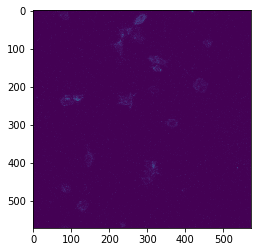

In [17]:
import matplotlib.pyplot as plt
plt.imshow(im[0][:,:,2])
# print(im[0])

In [18]:
results = unet_model.predict(im)

NameError: name 'unet_model' is not defined

In [ ]:
plt.imshow(results[3][:,:,1])

In [19]:
import json
history2_file = os.path.join(OUTPUT_PATH,base_name+'.json')
history_v2_dict = history.history
json.dump(str(history_v2_dict), open(history2_file, 'w'))

In [ ]:
# print(str(history_v2_dict))

In [ ]:
histoty